In [121]:
import random
import numpy as np
import pandas as pd
from pylab import *
     

# Base code for simulation testing

In [135]:
def test_algorithm(cache_size, prompt_num, num_sims, horizon, alpha = 1, p_small = 0.5, p_large = 0.5):
    
    # Initialize all cost as 0
    cost_lfu_s = np.zeros((num_sims, horizon+1)) 
    cost_lfu_l = np.zeros((num_sims, horizon+1)) 
    cost_lec = np.zeros((num_sims, horizon+1)) 
    cost_true = np.zeros((num_sims, horizon+1)) 
    
    # Iterate over rounds of sim
    for sim in range(num_sims):
        
        ## Initialize all cache to empty
        cache_lfu = np.zeros(prompt_num)
        cache_lec = np.zeros(prompt_num)
        cache_true = np.zeros(prompt_num)
        
        ## Initialize all cost estimated sum and frequency estimate to 0 
        small_cost_sum = np.zeros(prompt_num)
        large_cost_sum = np.zeros(prompt_num)
        freq_est = np.zeros(prompt_num)
        small_freq_est = np.zeros(prompt_num)
        large_freq_est = np.zeros(prompt_num)
        
        ## Generate ground truth 
        freq_true = np.random.power(alpha,size = prompt_num)
        freq_true = freq_true / sum(freq_true)
        visited_query = np.random.choice(prompt_num, horizon, p=freq_true)

        small_cost_true = np.random.binomial(n=1, p=p_small, size = prompt_num) * 100 + 1 #  np.random.uniform(low=1, high=100, size = prompt_num) 
        large_cost_true = np.random.binomial(n=1, p=p_large, size = prompt_num) * 100 + 1
        
        expected_cost_true = freq_true * np.minimum(small_cost_true, large_cost_true)
         
        ## Calculate the ground truth cache
        cache_true[np.argpartition(expected_cost_true, -cache_size)[-cache_size:]] = 1
        
        
        # Start T = horizon iterations
        for time in range(horizon):
            query = visited_query[time]
            small_cost = small_cost_true[query] + np.random.normal(0, 1)
            large_cost = large_cost_true[query] + np.random.normal(0, 1)
            freq_est[query] += 1

            # LFU cache 
            
            ## Hit cache or not
            if cache_lfu[query] != 1:
                cost_lfu_s[sim, time+1] = cost_lfu_s[sim, time] + small_cost
                cost_lfu_l[sim, time+1] = cost_lfu_l[sim, time] + large_cost
            else:
                cost_lfu_s[sim, time+1] = cost_lfu_s[sim, time]
                cost_lfu_l[sim, time+1] = cost_lfu_l[sim, time] 
                
            ## Cache replacement
            
            if np.sum(cache_lfu) < cache_size:
                cache_lfu[query] = 1
            elif time > 0:
                freq_idx = np.argmin(freq_est[cache_lfu == 1])
                for j in range(prompt_num):
                    if np.sum(cache_lfu[:j+1]) == freq_idx+1:
                        freq_idx = j
                        break
                if freq_est[query] > freq_est[freq_idx]:
                    cache_lfu[query] = 1
                    cache_lfu[freq_idx] = 0
            
            # LEC cache
            
            ## Update cost estimate
            
            small_cost_est = np.maximum(small_cost_sum/small_freq_est - np.sqrt(prompt_num / small_freq_est), 1)
            small_cost_est[small_freq_est == 0] = 1
            large_cost_est = np.maximum(large_cost_sum/large_freq_est - np.sqrt(prompt_num / large_freq_est), 1)
            large_cost_est[large_freq_est == 0] = 1
            expected_cost_est = freq_est * np.minimum(small_cost_est, large_cost_est)
            
            
            ## Hit cache or not
            if cache_lec[query] != 1:
                
                if small_cost_est[query] < large_cost_est[query]:
                    cost_lec[sim, time+1] = cost_lec[sim, time] + small_cost
                    small_cost_sum[query] += small_cost
                    small_freq_est[query] += 1
                else:
                    cost_lec[sim, time+1] = cost_lec[sim, time] + large_cost
                    large_cost_sum[query] += large_cost
                    large_freq_est[query] += 1
            else:
                cost_lec[sim, time+1] = cost_lec[sim, time]      
            
            
            ## Cache replacement
            
            if np.sum(cache_lec) < cache_size:
                cache_lec[query] = 1
            elif time > 0:
                cost_idx = np.argmin(expected_cost_est[cache_lec == 1])
                for j in range(prompt_num):
                    if np.sum(cache_lec[:j+1]) == cost_idx+1:
                        cost_idx = j
                        break
                # print(np.min(expected_cost_est[cache_lec == 1]), expected_cost_est[cost_idx])
                if expected_cost_est[query] > expected_cost_est[cost_idx]:
                    cache_lec[query] = 1
                    cache_lec[cost_idx] = 0
                    
                    
            # Ground Truth
            if cache_true[query] != 1:
                if small_cost_true[query] < large_cost_true[query]:
                    cost_true[sim, time+1] = cost_true[sim, time] + small_cost
                else:
                    cost_true[sim, time+1] = cost_true[sim, time] + large_cost
            else:
                cost_true[sim, time+1] = cost_true[sim, time]      
                            
    return [cost_lfu_s, cost_lfu_l, cost_lec, cost_true]

C:\Users\admin\AppData\Local\Temp\ipykernel_12688\3609598018.py:73: RuntimeWarning: invalid value encountered in divide
  small_cost_est = np.maximum(small_cost_sum/small_freq_est - np.sqrt(prompt_num / small_freq_est), 1)
C:\Users\admin\AppData\Local\Temp\ipykernel_12688\3609598018.py:73: RuntimeWarning: divide by zero encountered in divide
  small_cost_est = np.maximum(small_cost_sum/small_freq_est - np.sqrt(prompt_num / small_freq_est), 1)
C:\Users\admin\AppData\Local\Temp\ipykernel_12688\3609598018.py:75: RuntimeWarning: invalid value encountered in divide
  large_cost_est = np.maximum(large_cost_sum/large_freq_est - np.sqrt(prompt_num / large_freq_est), 1)
C:\Users\admin\AppData\Local\Temp\ipykernel_12688\3609598018.py:75: RuntimeWarning: divide by zero encountered in divide
  large_cost_est = np.maximum(large_cost_sum/large_freq_est - np.sqrt(prompt_num / large_freq_est), 1)


[0.00000000e+00 4.80125785e+01 7.60455783e+01 ... 1.18416248e+05
 1.18425544e+05 1.18434922e+05]
[0.00000000e+00 4.79089041e+01 9.99630063e+01 ... 1.53280133e+05
 1.53294390e+05 1.53310688e+05]
[   0.           47.90890407   99.96300629 ... 5137.40169105 5137.6935172
 5138.15492362]
[0.00000000e+00 2.64816751e-01 6.25021414e-01 ... 3.21124218e+03
 3.21150472e+03 3.21192911e+03]


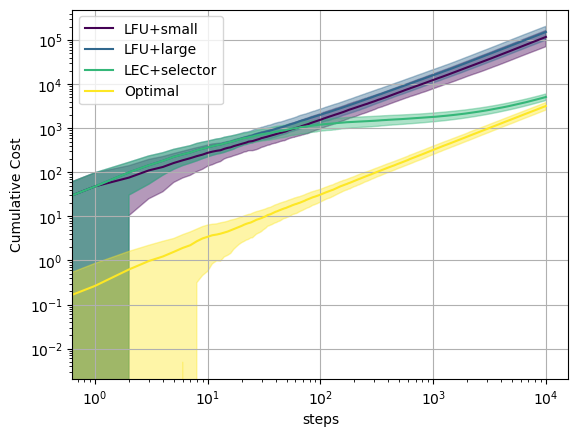

In [144]:
cmap = plt.get_cmap('viridis')
nline = 4
horizon = 10000
res_seq = test_algorithm(cache_size = 10, prompt_num = 20, num_sims = 100, horizon = horizon, p_small = 0.4)
steps = np.array(range(horizon+1))
labeling = {0: "LFU+small", 1: "LFU+large", 2: "LEC+selector", 3: "Optimal"}
for i in range(len(res_seq)):
    mean_seq = np.mean(res_seq[i], axis=0)
    print(mean_seq)
    std_seq = np.sqrt(np.var(res_seq[i], axis=0))
    plot(steps, mean_seq, label=labeling[i], color = cmap(i/(nline-1)))
    fill_between(steps, mean_seq+std_seq, mean_seq-std_seq, color=cmap(i/(nline-1)), alpha=0.4)

plt.xscale('log')
plt.yscale('log')
legend()
xlabel('steps')
plt.grid()
# title('Online Policy Optimization with 125M model')
ylabel('Cumulative Cost')
plt.savefig("cumulative_cost.pdf", format='pdf')


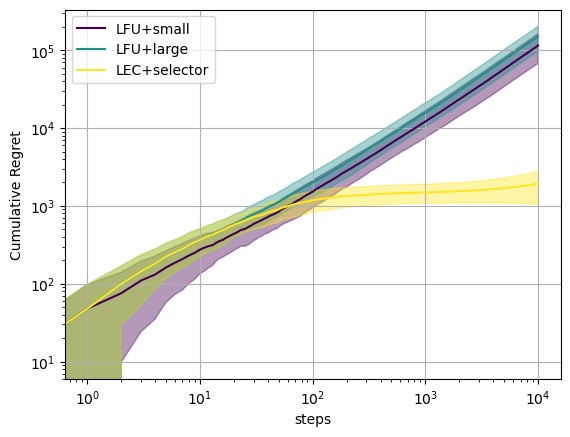

In [148]:
steps = np.array(range(horizon+1))
nline = 3
optimal_seq_mean = np.mean(res_seq[-1], axis=0)
labeling = {0: "LFU+small", 1: "LFU+large", 2: "LEC+selector"}
for i in range(len(res_seq)-1):
    mean_seq = np.mean(res_seq[i], axis=0)
    std_seq = np.sqrt(np.var(res_seq[i], axis=0))
    plot(steps, mean_seq-optimal_seq_mean, label=labeling[i], color = cmap(i/(nline-1)))
    fill_between(steps, mean_seq-optimal_seq_mean+std_seq, mean_seq-optimal_seq_mean-std_seq, color=cmap(i/(nline-1)), alpha=0.4)

plt.xscale('log')
plt.yscale('log')
legend()
xlabel('steps')
plt.grid()
# title('Online Policy Optimization with 125M model')
ylabel('Cumulative Regret')
plt.savefig("cumulative_regret.pdf", format='pdf')